In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, roc_curve, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import shap
from scipy import sparse
import joblib

In [17]:
import pandas as pd

# # Load the original file
# df = pd.read_csv("../data/processed/merged_cleaned_trials.csv")

# # Save a copy with a new name
# df.to_csv("nlp_merged_cleaned_trials.csv", index=False)


In [3]:
df = pd.read_csv('../data/processed/nlp_merged_cleaned_trials.csv')

In [4]:
df.columns

Index(['NCT Number', 'study_title', 'study_status', 'brief_summary',
       'conditions', 'interventions', 'primary_outcome_measures',
       'secondary_outcome_measures', 'sponsor', 'enrollment', 'study_type',
       'study_design', 'last_update_posted', 'locations',
       'study_duration_days', 'sex_all', 'sex_female', 'sex_male', 'has_child',
       'has_adult', 'has_older_adult', 'phase1', 'phase2', 'phase3',
       'funder_fed', 'funder_indiv', 'funder_industry', 'funder_network',
       'funder_nih', 'funder_other', 'funder_other_gov', 'funder_unknown',
       'missing_start_date', 'missing_primary_completion_date',
       'missing_completion_date'],
      dtype='object')

In [5]:
df = df.drop('NCT Number', axis=1)

In [6]:
df.dtypes

study_title                         object
study_status                         int64
brief_summary                       object
conditions                          object
interventions                       object
primary_outcome_measures            object
secondary_outcome_measures          object
sponsor                             object
enrollment                           int64
study_type                          object
study_design                        object
last_update_posted                  object
locations                           object
study_duration_days                float64
sex_all                               bool
sex_female                            bool
sex_male                              bool
has_child                            int64
has_adult                            int64
has_older_adult                      int64
phase1                               int64
phase2                               int64
phase3                               int64
funder_fed 

In [7]:
object_cols = df.select_dtypes(include=['object']).columns
print(object_cols)

Index(['study_title', 'brief_summary', 'conditions', 'interventions',
       'primary_outcome_measures', 'secondary_outcome_measures', 'sponsor',
       'study_type', 'study_design', 'last_update_posted', 'locations'],
      dtype='object')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'min_samples_leaf': 20, 'max_leaf_nodes': 31, 'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.05}

Cross-Validated Training Metrics:
Accuracy: 0.89
ROC AUC: 0.90
Precision: 0.90
Recall: 0.97
F1 Score: 0.93

Test Set Metrics:
Accuracy: 0.89
ROC AUC: 0.90
Precision: 0.90
Recall: 0.97
F1 Score: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       306
           1       0.90      0.97      0.93      1030

    accuracy                           0.89      1336
   macro avg       0.88      0.79      0.83      1336
weighted avg       0.89      0.89      0.88      1336



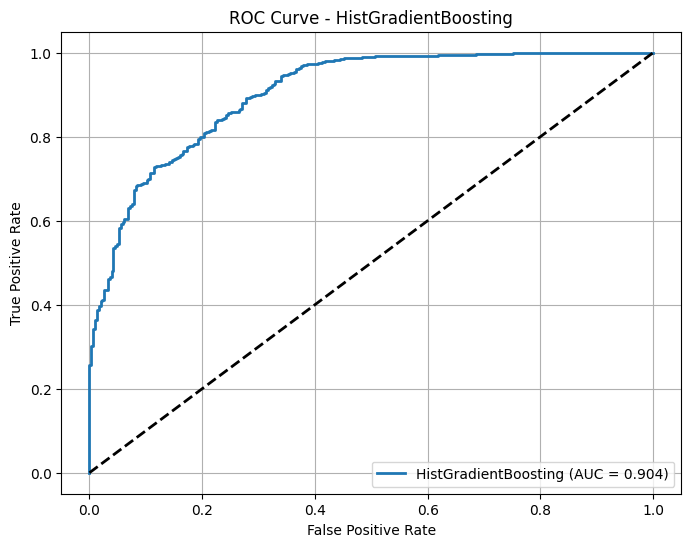

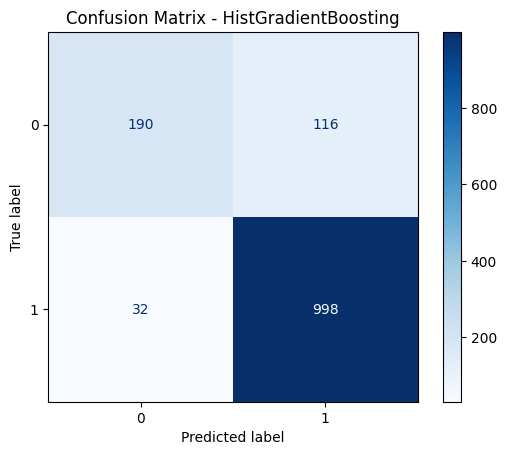

In [ ]:
# --- Data Preparation ---

# Numeric columns (exclude sponsor, study_type, study_design from numeric because they are categorical)
numeric_cols = ['enrollment', 'study_duration_days',
                'sex_all', 'sex_female', 'sex_male', 'has_child', 'has_adult',
                'has_older_adult', 'phase1', 'phase2', 'phase3', 'funder_fed',
                'funder_indiv', 'funder_industry', 'funder_network', 'funder_nih',
                'funder_other', 'funder_other_gov', 'funder_unknown',
                'missing_start_date', 'missing_primary_completion_date', 'missing_completion_date']

# Categorical columns that are currently object type (should be converted before modeling)
cat_cols = ['sponsor', 'study_type', 'study_design']

text_cols = ['study_title', 'brief_summary', 'conditions', 'interventions',
             'primary_outcome_measures', 'secondary_outcome_measures', 'locations']

# Fill NaNs in text columns with empty strings
df[text_cols] = df[text_cols].fillna('')

# Combine all text columns into one for TF-IDF vectorization
df['combined_text'] = df[text_cols].agg(' '.join, axis=1)

# Fill missing numeric values with median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical with 'Unknown'
df[cat_cols] = df[cat_cols].fillna('Unknown')

# One-hot encode categorical columns (use get_dummies for simplicity)
df_cat_encoded = pd.get_dummies(df[cat_cols], drop_first=True)

# Save the categorical columns used after encoding for later use in prediction
onehot_cat_columns = df_cat_encoded.columns.tolist()
joblib.dump(onehot_cat_columns, 'onehot_cat_columns.pkl')

# TF-IDF vectorizer on combined text column
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(df['combined_text'])

# Convert TF-IDF sparse matrix to dense (be cautious if dataset is large)
X_text_dense = X_text.toarray()

# Numeric data as numpy array
X_numeric = df[numeric_cols].values

# Concatenate numeric + categorical + text features
X = np.hstack([X_numeric, df_cat_encoded.values, X_text_dense])

# Target variable
y = df['study_status'].values

# --- Train/Test Split ---
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12, test_size=0.2)

# --- Model and Hyperparameter Tuning ---

hgb = HistGradientBoostingClassifier(random_state=12)

param_grid = {
    'max_iter': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [20, 50],
    'max_leaf_nodes': [15, 31]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

random_search = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_grid,
    n_iter=10,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=12
)
random_search.fit(x_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
best_hgb = random_search.best_estimator_

# --- Cross-Validated Predictions on Training Set ---
y_proba_cv = cross_val_predict(best_hgb, x_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_cv = (y_proba_cv >= 0.5).astype(int)

print("\nCross-Validated Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_cv):.2f}")
print(f"ROC AUC: {roc_auc_score(y_train, y_proba_cv):.2f}")
print(f"Precision: {precision_score(y_train, y_pred_cv):.2f}")
print(f"Recall: {recall_score(y_train, y_pred_cv):.2f}")
print(f"F1 Score: {f1_score(y_train, y_pred_cv):.2f}")

# --- Test Set Evaluation ---
y_pred_test = best_hgb.predict(x_test)
y_proba_test = best_hgb.predict_proba(x_test)[:, 1]

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_test):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# --- ROC Curve Plot ---
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'HistGradientBoosting (AUC = {roc_auc_score(y_test, y_proba_test):.3f})', lw=2)
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - HistGradientBoosting')
plt.legend()
plt.grid(True)
plt.show()

# --- Confusion Matrix Plot ---
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues')
plt.title('Confusion Matrix - HistGradientBoosting')
plt.show()

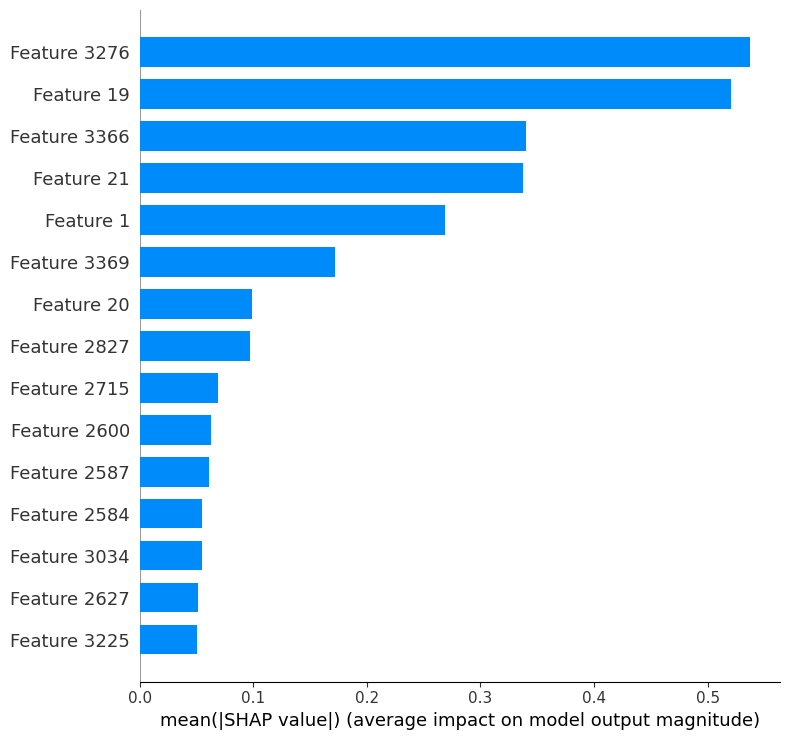

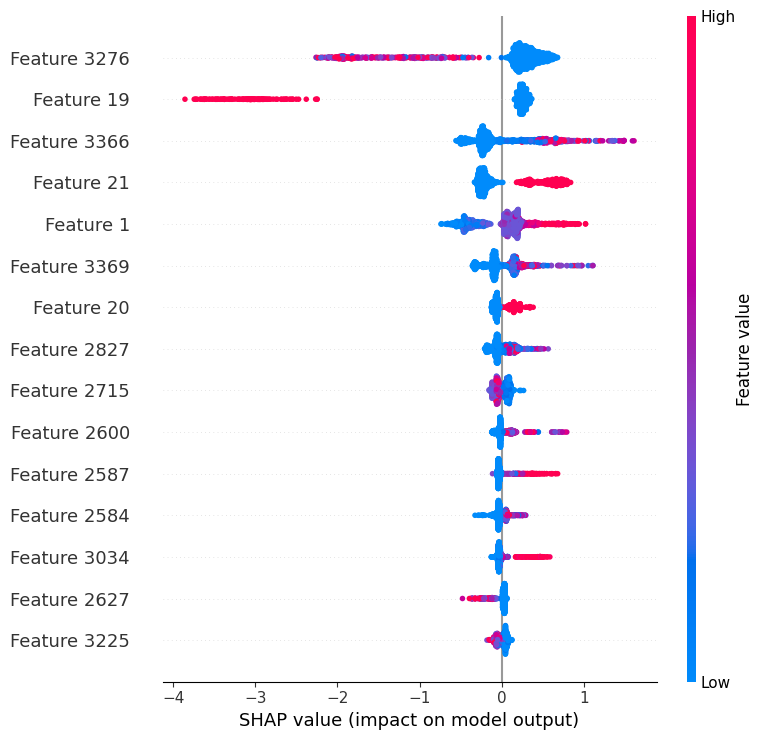

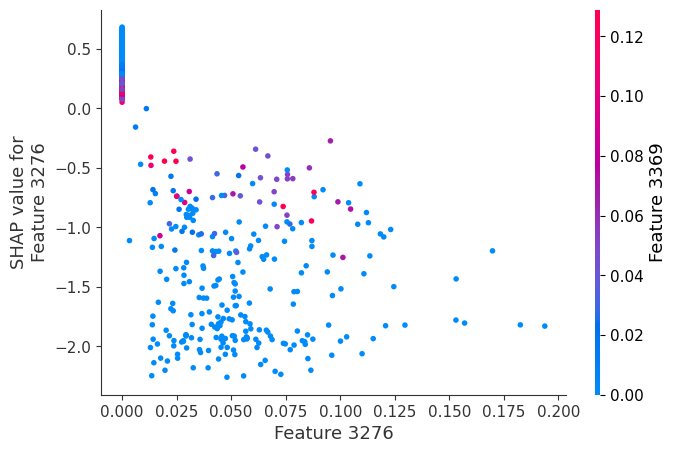

In [9]:
# --- SHAP Explainability ---
explainer = shap.Explainer(best_hgb)
shap_values = explainer(x_test)

plt.figure(figsize=(10,8))
shap.summary_plot(shap_values, x_test, plot_type='bar', max_display=15, show=True)

plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, x_test, max_display=15)

# Dependence plot for top feature
top_feature_idx = np.argmax(np.abs(shap_values.values).mean(axis=0))
shap.dependence_plot(top_feature_idx, shap_values.values, x_test)

In [12]:
import joblib

# After fitting your vectorizer during training
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(best_hgb, 'best_xgb_model.pkl')


['best_xgb_model.pkl']

In [19]:
onehot_cat_columns = df_cat_encoded.columns.tolist()
joblib.dump(onehot_cat_columns, 'onehot_cat_columns.pkl')

['onehot_cat_columns.pkl']

In [ ]:
import pandas as pd 
import numpy as np
import joblib
from scipy.sparse import csr_matrix, hstack

# --- Load saved artifacts ---
tfidf_vectorizer = joblib.load('../models/tfidf_vectorizer.pkl')  
best_hgb = joblib.load('../models/best_hgb_model.pkl')            
onehot_cat_columns = joblib.load('../models/onehot_cat_columns.pkl')  

# --- New input data dictionary ---
new_data_dict = {
    'enrollment': 150,
    'study_duration_days': 120.0,
    'sex_all': True,
    'sex_female': False,
    'sex_male': True,
    'has_child': 0,
    'has_adult': 1,
    'has_older_adult': 0,
    'phase1': 0,
    'phase2': 1,
    'phase3': 0,
    'funder_fed': False,
    'funder_indiv': False,
    'funder_industry': True,
    'funder_network': False,
    'funder_nih': False,
    'funder_other': False,
    'funder_other_gov': False,
    'funder_unknown': False,
    'missing_start_date': 0,
    'missing_primary_completion_date': 0,
    'missing_completion_date': 0,
    'sponsor': 'Pfizer',
    'study_type': 'Interventional',
    'study_design': 'Randomized',
    'study_title': 'A study on cancer treatment',
    'brief_summary': 'This clinical trial tests new medication for cancer.',
    'conditions': 'Breast cancer',
    'interventions': 'Drug X',
    'primary_outcome_measures': 'Tumor size reduction',
    'secondary_outcome_measures': 'Survival rate',
    'locations': 'New York, NY'
}

# --- Convert dictionary to DataFrame ---
new_df = pd.DataFrame([new_data_dict])

# --- Define feature columns ---
numeric_cols = [
    'enrollment', 'study_duration_days', 'sex_all', 'sex_female', 'sex_male',
    'has_child', 'has_adult', 'has_older_adult', 'phase1', 'phase2', 'phase3',
    'funder_fed', 'funder_indiv', 'funder_industry', 'funder_network',
    'funder_nih', 'funder_other', 'funder_other_gov', 'funder_unknown',
    'missing_start_date', 'missing_primary_completion_date', 'missing_completion_date'
]

cat_cols = ['sponsor', 'study_type', 'study_design']

text_cols = [
    'study_title', 'brief_summary', 'conditions', 'interventions',
    'primary_outcome_measures', 'secondary_outcome_measures', 'locations'
]

# --- Handle missing values for categorical and text columns ---
new_df[cat_cols] = new_df[cat_cols].fillna('Unknown')
new_df[text_cols] = new_df[text_cols].fillna('')

# --- One-hot encode categorical columns ---
new_cat_encoded = pd.get_dummies(new_df[cat_cols])

# --- Align one-hot encoded columns with training columns ---

# Identify missing columns that need to be added
missing_cols = [col for col in onehot_cat_columns if col not in new_cat_encoded.columns]

if missing_cols:
    # Create DataFrame of zeros for missing columns with same index as new_cat_encoded
    missing_df = pd.DataFrame(0, index=new_cat_encoded.index, columns=missing_cols)
    # Concatenate all missing columns at once to avoid fragmentation warning
    new_cat_encoded = pd.concat([new_cat_encoded, missing_df], axis=1)

# Drop any extra columns not in training (safe check)
new_cat_encoded = new_cat_encoded[onehot_cat_columns]

# --- Combine all text columns into one string and transform using TF-IDF ---
new_df['combined_text'] = new_df[text_cols].agg(' '.join, axis=1)
X_text = tfidf_vectorizer.transform(new_df['combined_text'])

# --- Prepare numeric features as sparse matrix ---
X_num = csr_matrix(new_df[numeric_cols].astype(float).values)

# --- Convert categorical one-hot encoded data to sparse matrix ---
X_cat = csr_matrix(new_cat_encoded.values)

# --- Stack all features horizontally ---
X_input_sparse = hstack([X_num, X_cat, X_text])

# --- Convert to dense array if model requires dense input ---
X_input = X_input_sparse.toarray()

total_features = X_num.shape[1] + X_cat.shape[1] + X_text.shape[1]

# --- Perform prediction ---
y_pred = best_hgb.predict(X_input)
y_prob = best_hgb.predict_proba(X_input)[:, 1]

print("✅ Predicted class:", y_pred[0])
print("🔮 Probability of ACTIVE status:", round(y_prob[0], 2))

✅ Predicted class: 1
🔮 Probability of ACTIVE status: 0.85
